# TBV Outputs analyser
Let's compare the feedback provided during the active and sham runs of the experiment.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd

from src.my_settings import settings
from src.utils import parse_prt_file

sett = settings()

In [2]:
# Folder with the npz files
npy_path = os.path.join(sett["bids_path"], "derivatives", "tbv-script-outs")

# Get all the npz files
npy_files = [
    f for f in os.listdir(npy_path) if f.endswith(".npz") and f.startswith("sub-")
]

# Sort the files
npy_files.sort()

print(
    f"Found {len(npy_files)} npz files. Expecter number is 22 (subjects) x 4 (runs) = 88"
)

Found 88 npz files. Expecter number is 22 (subjects) x 4 (runs) = 88


# Protocol

In [3]:
# Read PRT file
prtPath = os.path.join(
    sett["git_path"], "data", "prt", "MusicNF_Main_v0.3_PostDiscard.prt"
)
conditions, cond_names = parse_prt_file(prtPath)

# delete first row of condition['Rest']
conditions["Rest"] = np.delete(conditions["Rest"], 0, 0)

In [4]:
indexes_rest = [np.arange(i[0], i[1] + 1) for i in conditions["Rest"]]
indexes_rest

[array([41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
        58, 59, 60]),
 array([ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100]),
 array([121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 136, 137, 138, 139, 140]),
 array([161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
        174, 175, 176, 177, 178, 179, 180]),
 array([201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
        214, 215, 216, 217, 218, 219, 220])]

In [5]:
indexes_mi = [np.arange(i[0], i[1] + 1) for i in conditions["MotorImagery"]]
indexes_mi

[array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
        38, 39, 40]),
 array([61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
        78, 79, 80]),
 array([101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
        114, 115, 116, 117, 118, 119, 120]),
 array([141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160]),
 array([181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200]),
 array([221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
        234, 235, 236, 237, 238, 239, 240])]

# Iteration for data extraction

Each row correponds to one trial. So the expected number of rows is 22 (subjects) x 4 (runs) x (5 MI + 6 Rest) = 968 rows.

In [6]:
# Initalize the data frame
df = pd.DataFrame(
    columns=[
        "sub",
        "feedback",
        "correlation_tc",
        "correlation_mean",
        "correlation_mean_first_half",
        "correlation_mean_second_half",
        "bold_tcs",
    ]
)

# Loop through all the files
for npy_file in npy_files:
    # Get the subject number
    sub = npy_file.split("_")[0]

    # Get the feedback type
    feedback = npy_file.split("_")[2].lower()

    if feedback == "active":
        rest_str = "rest_active"
    elif feedback == "sham":
        rest_str = "rest_sham"

    # Load the file
    data = np.load(os.path.join(npy_path, npy_file))

    pc = data["PearsonCorr"]

    # delete all numbers above 1 and below -1 (invalid values due to window)
    pc[pc > 1] = np.nan
    pc[pc < -1] = np.nan

    # fisher transform
    pc = np.arctanh(pc)

    # bold
    bold = data["ROImeans"]

    # normalize bold to the mean of the full bold signal
    # mean per ROI
    bold_m = np.nanmean(bold, axis=0)
    bold = (bold - bold_m) / bold_m * 100

    # Get the correlations values for the Motor Imagery per trial and add to the data frame
    for ii in range(len(indexes_mi)):
        pc_mi = pc[indexes_mi[ii]]
        bold_mi = bold[indexes_mi[ii], :]

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    [
                        [
                            sub,
                            feedback,
                            pc_mi,
                            np.nanmean(pc_mi[3:]),
                            np.nanmean(pc_mi[3:11]),
                            np.nanmean(pc_mi[11:]),
                            bold_mi,
                        ]
                    ],
                    columns=df.columns,
                ),
            ]
        )

    # Get the correlations values for the Rest per trial and add to the data frame
    for ii in range(len(indexes_rest)):
        pc_rest = pc[indexes_rest[ii]]
        bold_rest = bold[indexes_rest[ii], :]

        df = pd.concat(
            [
                df,
                pd.DataFrame(
                    [
                        [
                            sub,
                            rest_str,
                            pc_rest,
                            np.nanmean(pc_rest[3:]),
                            np.nanmean(pc_rest[3:11]),
                            np.nanmean(pc_rest[11:]),
                            bold_rest,
                        ]
                    ],
                    columns=df.columns,
                ),
            ]
        )


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_17454/1341233366.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(


In [7]:
# save df to pickle
df.to_pickle(os.path.join(sett["git_path"], "data", "RealTimeTBVOutputs.pkl"))

# Load data

In [8]:
# load df
df = pd.read_pickle(os.path.join(sett["git_path"], "data", "RealTimeTBVOutputs.pkl"))

In [9]:
df

,sub,feedback,correlation_tc,correlation_mean,correlation_mean_first_half,correlation_mean_second_half,bold_tcs
0,sub-01,active,"[[0.8834017165931979], [0.5936351046975646], [...",1.200166,1.086382,1.301308,"[[0.07136824233484067, 0.6339088657642343], [0..."
0,sub-01,active,"[[0.639477209433777], [0.25846493532013015], [...",0.329233,0.140902,0.496638,"[[-0.29594867592321933, -0.11542613255553363],..."
0,sub-01,active,"[[0.6386867596114921], [0.16471422982690861], ...",1.245398,1.041823,1.426354,"[[-0.07384425422059404, -0.37413056480625184],..."
0,sub-01,active,"[[0.32111039996360463], [0.301462958566049], [...",1.181329,0.885283,1.444480,"[[-0.23614732106572844, -0.7041942457830699], ..."
0,sub-01,active,"[[1.6171461589082468], [1.7078990542699366], [...",0.854883,0.892086,0.821813,"[[0.23367130917997503, 0.2324745021166401], [0..."
...,...,...,...,...,...,...,...
0,sub-22,rest_sham,"[[1.1374085269142709], [0.9918071937144581], [...",1.375888,0.967285,1.739090,"[[1.0622663998094493, 0.7059418605723529], [0...."
0,sub-22,rest_sham,"[[1.3642629353359232], [1.2748679464285693], [...",1.969506,2.036856,1.909639,"[[1.0085947833639097, 0.7612340619113676], [0...."
0,sub-22,rest_sham,"[[1.7174490992780895], [1.457468820282638], [0...",1.647008,1.506377,1.772014,"[[0.4763273664370053, 0.4405280444601705], [0...."
0,sub-22,rest_sham,"[[1.0275823335920613], [1.225648824675699], [1...",1.143783,1.340490,0.968932,"[[0.570255561677736, 0.30044696794472553], [0...."


# Create dataframe with data per subject

In [10]:
# Get correlation_mean, correlation_mean_first_half, and correlation_mean_second_half for each subject and feedback type
df_persubject = df.groupby(["sub", "feedback"]).mean()
df_persubject

correlation_tc  \
sub    feedback                                                         
sub-01 active       [[0.9491462326419966], [0.8728542440724366], [...   
       rest_active  [[0.9094888998621184], [0.891023604422345], [0...   
       rest_sham    [[1.1033747129439275], [1.1030738154656319], [...   
       sham         [[0.9734436258870391], [0.8950921493312994], [...   
sub-02 active       [[0.6870329471695454], [0.6233786121717074], [...   
       rest_active  [[0.9602507599424159], [0.947976839845022], [0...   
       rest_sham    [[0.8938614429371976], [0.8017734066242455], [...   
       sham         [[1.210994882722792], [1.1034345978047109], [1...   
sub-03 active       [[0.4103036783045442], [0.4326364126356264], [...   
       rest_active  [[0.5549342709761131], [0.5197685892878166], [...   
       rest_sham    [[0.187933394680408], [0.1820138977922313], [0...   
       sham         [[0.5535417916168891], [0.5983433402793237], [...   
sub-04 active       [[0.8351683966135046], [0.6757506595653463], [...   
       rest_active  [[0.7264071607610982], [0.7246365053095665], [...   
       rest_sham    [[0.8702093155491782], [0.7538090949691783], [...   
       sham         [[0.5076586597274355], [0.5389822580806616], [...   
sub-05 active       [[0.7836925509370624], [0.7106594733271855], [...   
       rest_active  [[1.1982666258517907], [1.149246612142553], [1...   
       rest_sham    [[0.9585302937153095], [0.8459510893768837], [...   
       sham         [[0.9497758988972523], [0.8794872994159344], [...   
sub-06 active       [[1.0921025072491999], [1.044105963737873], [1...   
       rest_active  [[0.8031936810183347], [0.6774029612688814], [...   
       rest_sham    [[1.1535674293911922], [1.1164707852202984], [...   
       sham         [[0.8610588758707883], [0.9488899014968141], [...   
sub-07 active       [[0.653013399824093], [0.6224873363213116], [0...   
       rest_active  [[0.3175234745349929], [0.20316226873884352], ...   
       rest_sham    [[1.0326669846840224], [1.1261273089728463], [...   
       sham         [[0.7366219677572851], [0.7033683747577961], [...   
sub-08 active       [[0.895138502305214], [0.837598857737674], [0....   
       rest_active  [[0.6287972709161622], [0.7398059821605447], [...   
       rest_sham    [[0.5905523063309583], [0.542279610894321], [0...   
       sham         [[0.5799958257261465], [0.6910779273992792], [...   
sub-09 active       [[1.2053618416131795], [1.1686134852018455], [...   
       rest_active  [[0.8813167048963988], [0.9603192546708138], [...   
       rest_sham    [[1.0134727125280878], [1.0389772887204027], [...   
       sham         [[0.8691277863477671], [0.9404031943155493], [...   
sub-10 active       [[1.1164255663394613], [1.136263579707882], [0...   
       rest_active  [[0.9764965404233059], [1.0061305243390197], [...   
       rest_sham    [[1.307993129286127], [1.2363197898667855], [1...   
       sham         [[1.0881694546860847], [1.0760098102368247], [...   
sub-11 active       [[1.026148204178893], [1.0018510003086332], [0...   
       rest_active  [[1.029883840220309], [1.174752923352914], [1....   
       rest_sham    [[0.9169734113223018], [0.9851756755122671], [...   
       sham         [[0.9906578703077438], [1.0276195881620065], [...   
sub-12 active       [[0.6627298428073954], [0.6927699528287775], [...   
       rest_active  [[0.4694164316234669], [0.43065078702847037], ...   
       rest_sham    [[0.45990113322814974], [0.4817159160840462], ...   
       sham         [[0.6140763478428138], [0.5859793159198249], [...   
sub-13 active       [[1.270779115612054], [1.3600854203249522], [1...   
       rest_active  [[1.1869313049475319], [1.310274754316302], [1...   
       rest_sham    [[1.2166215328318934], [1.2387514776558946], [...   
       sham         [[1.3090391082945154], [1.2266070851967064], [...   
sub-14 active       [[0.7600319675222766], [0.6550388769263563], [...   
       rest_active  [[0.5997757629908809

# Violin plots of the correlations

## Full block

A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'active' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'active' condition (Mdn = 1.11) compared to the 'rest' condition (Mdn = 1.00),  W = 215.00 ,  p = 0.001  (one-tailed).
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active vs. rest: Custom statistical test, P_val:1.426e-03
A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'sham' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'sham' condition (Mdn = 1.11) compared to the 'rest' condition (Mdn = 1.00),  W = 201.00 ,  p = 0.007  (one-tailed).
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.0

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


(<Axes: ylabel='Correlation mean (Fisher transformed)'>,
 [<statannotations.Annotation.Annotation at 0x306eb3e30>])

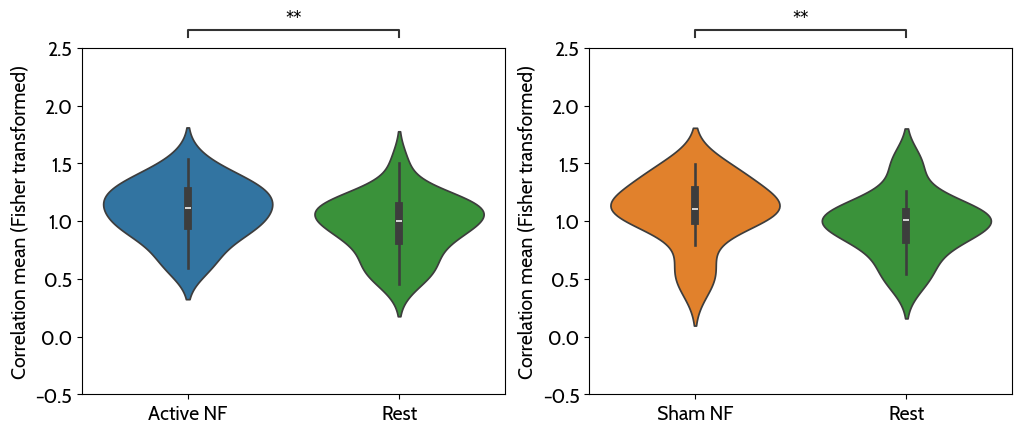

In [18]:
# Create a subplot (1,2) for the two feedback types. In each, violin plot the correlation mean and annotate the statistical comparison across subjects between active/sham and rest_active/rest_sham
# The dataframe to use is df_persubject

# Import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon

# colors use the lines colormap - blue for active, orange for sham, green for rest
colors = sns.color_palette("tab10", 3)

fig, axs = plt.subplots(1, 2, figsize=(12, 4.5))

# First subplot - active and rest_active data only
# get active and rest_active data
df_active = df_persubject.loc[(slice(None), "active"), :].copy()
df_rest_active = df_persubject.loc[(slice(None), "rest_active"), :].copy()
df_active.loc[:, "feedback"] = "active"
df_rest_active.loc[:, "feedback"] = "rest"
df_active = pd.concat([df_active, df_rest_active])

# plot
SP1 = sns.violinplot(
    x="feedback",
    y="correlation_mean",
    data=df_active,
    ax=axs[0],
    palette=[colors[0], colors[2]],
    hue="feedback",
)
axs[0].set_ylim(-0.5, 2.5)
axs[0].set_ylabel("Correlation mean (Fisher transformed)")
axs[0].set_xticks(np.arange(2))
axs[0].set_xticklabels(["Active NF", "Rest"])
axs[0].set_xlabel("")

# Perform one-sided Wilcoxon test manually
group1 = df_active[df_active["feedback"] == "active"]["correlation_mean"]
group2 = df_active[df_active["feedback"] == "rest"]["correlation_mean"]

stat, p_value = wilcoxon(group1, group2, alternative="greater")
print(
    f"A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'active' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'active' condition (Mdn = {group1.median():0.2f}) compared to the 'rest' condition (Mdn = {group2.median():0.2f}),  W = {stat:0.2f} ,  p = {p_value:0.3f}  (one-tailed)."
)

# add statistical annotation
annotator = Annotator(
    SP1,
    [("active", "rest")],
    data=df_active,
    x="feedback",
    y="correlation_mean",
    order=["active", "rest"],
)

# Manually set the computed p-value
annotator.set_pvalues([p_value])
annotator.configure(text_format="star", loc="outside")
annotator.annotate()


# Second subplot - sham and rest_sham data only
# get sham and rest_sham data
df_sham = df_persubject.loc[(slice(None), "sham"), :].copy()
df_rest_sham = df_persubject.loc[(slice(None), "rest_sham"), :].copy()
df_sham.loc[:, "feedback"] = "sham"
df_rest_sham.loc[:, "feedback"] = "rest"
df_sham = pd.concat([df_sham, df_rest_sham])

# plot
SP2 = sns.violinplot(
    x="feedback",
    y="correlation_mean",
    data=df_sham,
    ax=axs[1],
    palette=[colors[1], colors[2]],
    hue="feedback",
)
axs[1].set_ylim(-0.5, 2.5)
axs[1].set_ylabel("Correlation mean (Fisher transformed)")
axs[1].set_xticks(np.arange(2))
axs[1].set_xticklabels(["Sham NF", "Rest"])
axs[1].set_xlabel("")

# Perform one-sided Wilcoxon test manually
group1 = df_sham[df_sham["feedback"] == "sham"]["correlation_mean"]
group2 = df_sham[df_sham["feedback"] == "rest"]["correlation_mean"]

stat, p_value = wilcoxon(group1, group2, alternative="greater")
print(
    f"A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'sham' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'sham' condition (Mdn = {group1.median():0.2f}) compared to the 'rest' condition (Mdn = {group2.median():0.2f}),  W = {stat:0.2f} ,  p = {p_value:0.3f}  (one-tailed)."
)

# add statistical annotation
annotator = Annotator(
    SP2,
    [("sham", "rest")],
    data=df_sham,
    x="feedback",
    y="correlation_mean",
    order=["sham", "rest"],
)
annotator.set_pvalues([p_value])
annotator.configure(text_format="star", loc="outside")
annotator.annotate()


## First half

A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'active' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'active' condition (Mdn = 1.30) compared to the 'rest' condition (Mdn = 0.98),  W = 231.00 ,  p = 0.000  (one-tailed).
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active vs. rest: Custom statistical test, P_val:1.278e-04
A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'sham' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'sham' condition (Mdn = 1.32) compared to the 'rest' condition (Mdn = 0.97),  W = 231.00 ,  p = 0.000  (one-tailed).
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.0

/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "
/opt/anaconda3/envs/musicnf-novelinterface/lib/python3.13/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


(<Axes: ylabel='Correlation mean of the first half\n (Fisher transformed)'>,
 [<statannotations.Annotation.Annotation at 0x308687af0>])

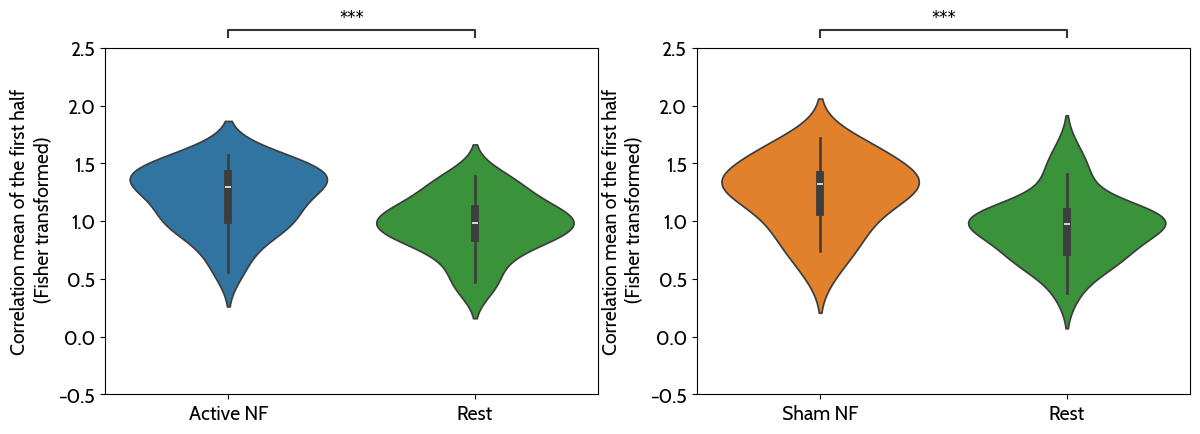

In [19]:
# Create a subplot (1,2) for the two feedback types. In each, violin plot the correlation mean and annotate the statistical comparison across subjects between active/sham and rest_active/rest_sham
# The dataframe to use is df_persubject

# Import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon

# colors use the lines colormap - blue for active, orange for sham, green for rest
colors = sns.color_palette("tab10", 3)

fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))

# First subplot - active and rest_active data only
# get active and rest_active data
df_active = df_persubject.loc[(slice(None), "active"), :].copy()
df_rest_active = df_persubject.loc[(slice(None), "rest_active"), :].copy()
df_active.loc[:, "feedback"] = "active"
df_rest_active.loc[:, "feedback"] = "rest"
df_active = pd.concat([df_active, df_rest_active])

# Perform one-sided Wilcoxon test manually
group1 = df_active[df_active["feedback"] == "active"]["correlation_mean_first_half"]
group2 = df_active[df_active["feedback"] == "rest"]["correlation_mean_first_half"]

stat, p_value = wilcoxon(group1, group2, alternative="greater")
print(
    f"A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'active' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'active' condition (Mdn = {group1.median():0.2f}) compared to the 'rest' condition (Mdn = {group2.median():0.2f}),  W = {stat:0.2f} ,  p = {p_value:0.3f}  (one-tailed)."
)

# plot
SP1 = sns.violinplot(
    x="feedback",
    y="correlation_mean_first_half",
    data=df_active,
    ax=axs[0],
    palette=[colors[0], colors[2]],
    hue="feedback",
)
axs[0].set_ylim(-0.5, 2.5)
axs[0].set_ylabel("Correlation mean of the first half\n (Fisher transformed)")
axs[0].set_xticks(np.arange(2))
axs[0].set_xticklabels(["Active NF", "Rest"])
axs[0].set_xlabel("")

# add statistical annotation
annotator = Annotator(
    SP1,
    [("active", "rest")],
    data=df_active,
    x="feedback",
    y="correlation_mean_first_half",
    order=["active", "rest"],
)

# Manually set the computed p-value
annotator.set_pvalues([p_value])

annotator.configure(text_format="star", loc="outside")
annotator.annotate()


# Second subplot - sham and rest_sham data only
# get sham and rest_sham data
df_sham = df_persubject.loc[(slice(None), "sham"), :].copy()
df_rest_sham = df_persubject.loc[(slice(None), "rest_sham"), :].copy()
df_sham.loc[:, "feedback"] = "sham"
df_rest_sham.loc[:, "feedback"] = "rest"
df_sham = pd.concat([df_sham, df_rest_sham])

# Perform one-sided Wilcoxon test manually
group1 = df_sham[df_sham["feedback"] == "sham"]["correlation_mean_first_half"]
group2 = df_sham[df_sham["feedback"] == "rest"]["correlation_mean_first_half"]

stat, p_value = wilcoxon(group1, group2, alternative="greater")

print(
    f"A one-sided Wilcoxon signed-rank test was conducted to compare mean correlation values between the 'sham' and 'rest' conditions. Results showed that correlation values were significantly higher in the 'sham' condition (Mdn = {group1.median():0.2f}) compared to the 'rest' condition (Mdn = {group2.median():0.2f}),  W = {stat:0.2f} ,  p = {p_value:0.3f}  (one-tailed)."
)

# plot
SP2 = sns.violinplot(
    x="feedback",
    y="correlation_mean_first_half",
    data=df_sham,
    ax=axs[1],
    palette=[colors[1], colors[2]],
    hue="feedback",
)
axs[1].set_ylim(-0.5, 2.5)
axs[1].set_ylabel("Correlation mean of the first half\n (Fisher transformed)")
axs[1].set_xticks(np.arange(2))
axs[1].set_xticklabels(["Sham NF", "Rest"])
axs[1].set_xlabel("")

# add statistical annotation
annotator = Annotator(
    SP2,
    [("sham", "rest")],
    data=df_sham,
    x="feedback",
    y="correlation_mean_first_half",
    order=["sham", "rest"],
)

# manually set the computed p-value
annotator.set_pvalues([p_value])
annotator.configure(text_format="star", loc="outside")
annotator.annotate()


## Second half

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

active vs. rest: Wilcoxon test (paired samples), P_val:3.209e-01 Stat=9.500e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sham vs. rest: Wilcoxon test (paired samples), P_val:4.826e-01 Stat=1.040e+02


(<Axes: ylabel='Correlation mean of the second half\n (Fisher transformed)'>,
 [<statannotations.Annotation.Annotation at 0x158543bf0>])

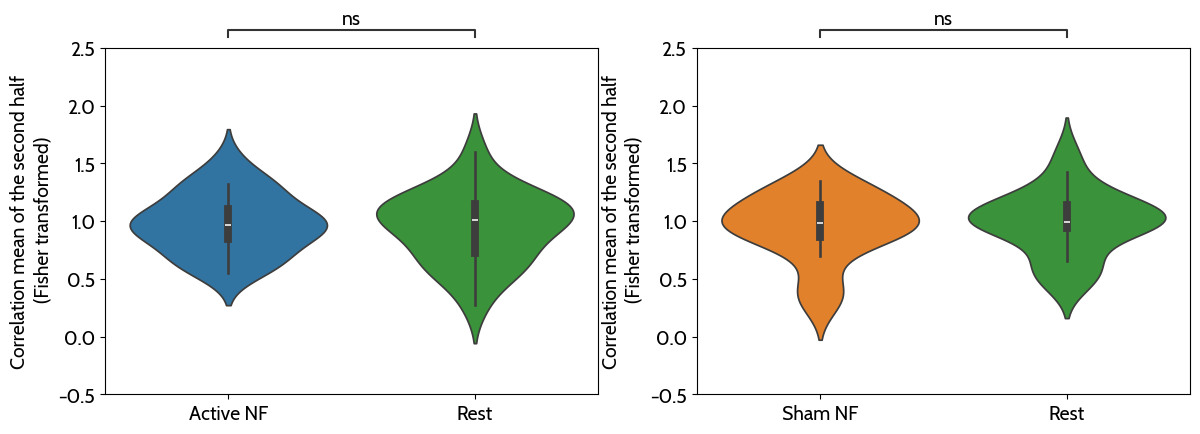

In [ ]:
# Create a subplot (1,2) for the two feedback types. In each, violin plot the correlation mean and annotate the statistical comparison across subjects between active/sham and rest_active/rest_sham
# The dataframe to use is df_persubject

# Import seaborn and matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# colors use the lines colormap - blue for active, orange for sham, green for rest
colors = sns.color_palette("tab10", 3)

fig, axs = plt.subplots(1, 2, figsize=(14, 4.5))

# First subplot - active and rest_active data only
# get active and rest_active data
df_active = df_persubject.loc[(slice(None), "active"), :].copy()
df_rest_active = df_persubject.loc[(slice(None), "rest_active"), :].copy()
df_active.loc[:, "feedback"] = "active"
df_rest_active.loc[:, "feedback"] = "rest"
df_active = pd.concat([df_active, df_rest_active])

# plot
SP1 = sns.violinplot(
    x="feedback",
    y="correlation_mean_second_half",
    data=df_active,
    ax=axs[0],
    palette=[colors[0], colors[2]],
    hue="feedback",
)
axs[0].set_ylim(-0.5, 2.5)
axs[0].set_ylabel("Correlation mean of the second half\n (Fisher transformed)")
axs[0].set_xticks(np.arange(2))
axs[0].set_xticklabels(["Active NF", "Rest"])
axs[0].set_xlabel("")

# add statistical annotation
annotator = Annotator(
    SP1,
    [("active", "rest")],
    data=df_active,
    x="feedback",
    y="correlation_mean_second_half",
    order=["active", "rest"],
)
annotator.configure(test="Wilcoxon", text_format="star", loc="outside")
annotator.apply_and_annotate()


# Second subplot - sham and rest_sham data only
# get sham and rest_sham data
df_sham = df_persubject.loc[(slice(None), "sham"), :].copy()
df_rest_sham = df_persubject.loc[(slice(None), "rest_sham"), :].copy()
df_sham.loc[:, "feedback"] = "sham"
df_rest_sham.loc[:, "feedback"] = "rest"
df_sham = pd.concat([df_sham, df_rest_sham])

# plot
SP2 = sns.violinplot(
    x="feedback",
    y="correlation_mean_second_half",
    data=df_sham,
    ax=axs[1],
    palette=[colors[1], colors[2]],
    hue="feedback",
)
axs[1].set_ylim(-0.5, 2.5)
axs[1].set_ylabel("Correlation mean of the second half\n (Fisher transformed)")
axs[1].set_xticks(np.arange(2))
axs[1].set_xticklabels(["Sham NF", "Rest"])
axs[1].set_xlabel("")

# add statistical annotation
annotator = Annotator(
    SP2,
    [("sham", "rest")],
    data=df_sham,
    x="feedback",
    y="correlation_mean_second_half",
    order=["sham", "rest"],
)
annotator.configure(test="Wilcoxon", text_format="star", loc="outside")
annotator.apply_and_annotate()


# Find modulator subjects

## Plot correlation curves per subject

Subject sub-01 has 0 significant points
Subject sub-02 has 6 significant points
Subject sub-03 has 8 significant points
Subject sub-04 has 2 significant points
Subject sub-05 has 6 significant points
Subject sub-06 has 0 significant points
Subject sub-07 has 7 significant points
Subject sub-08 has 3 significant points
Subject sub-09 has 1 significant points
Subject sub-10 has 10 significant points
Subject sub-11 has 2 significant points
Subject sub-12 has 0 significant points
Subject sub-13 has 1 significant points
Subject sub-14 has 2 significant points
Subject sub-15 has 4 significant points
Subject sub-16 has 4 significant points
Subject sub-17 has 3 significant points
Subject sub-18 has 3 significant points
Subject sub-19 has 12 significant points
Subject sub-20 has 2 significant points
Subject sub-21 has 4 significant points
Subject sub-22 has 3 significant points


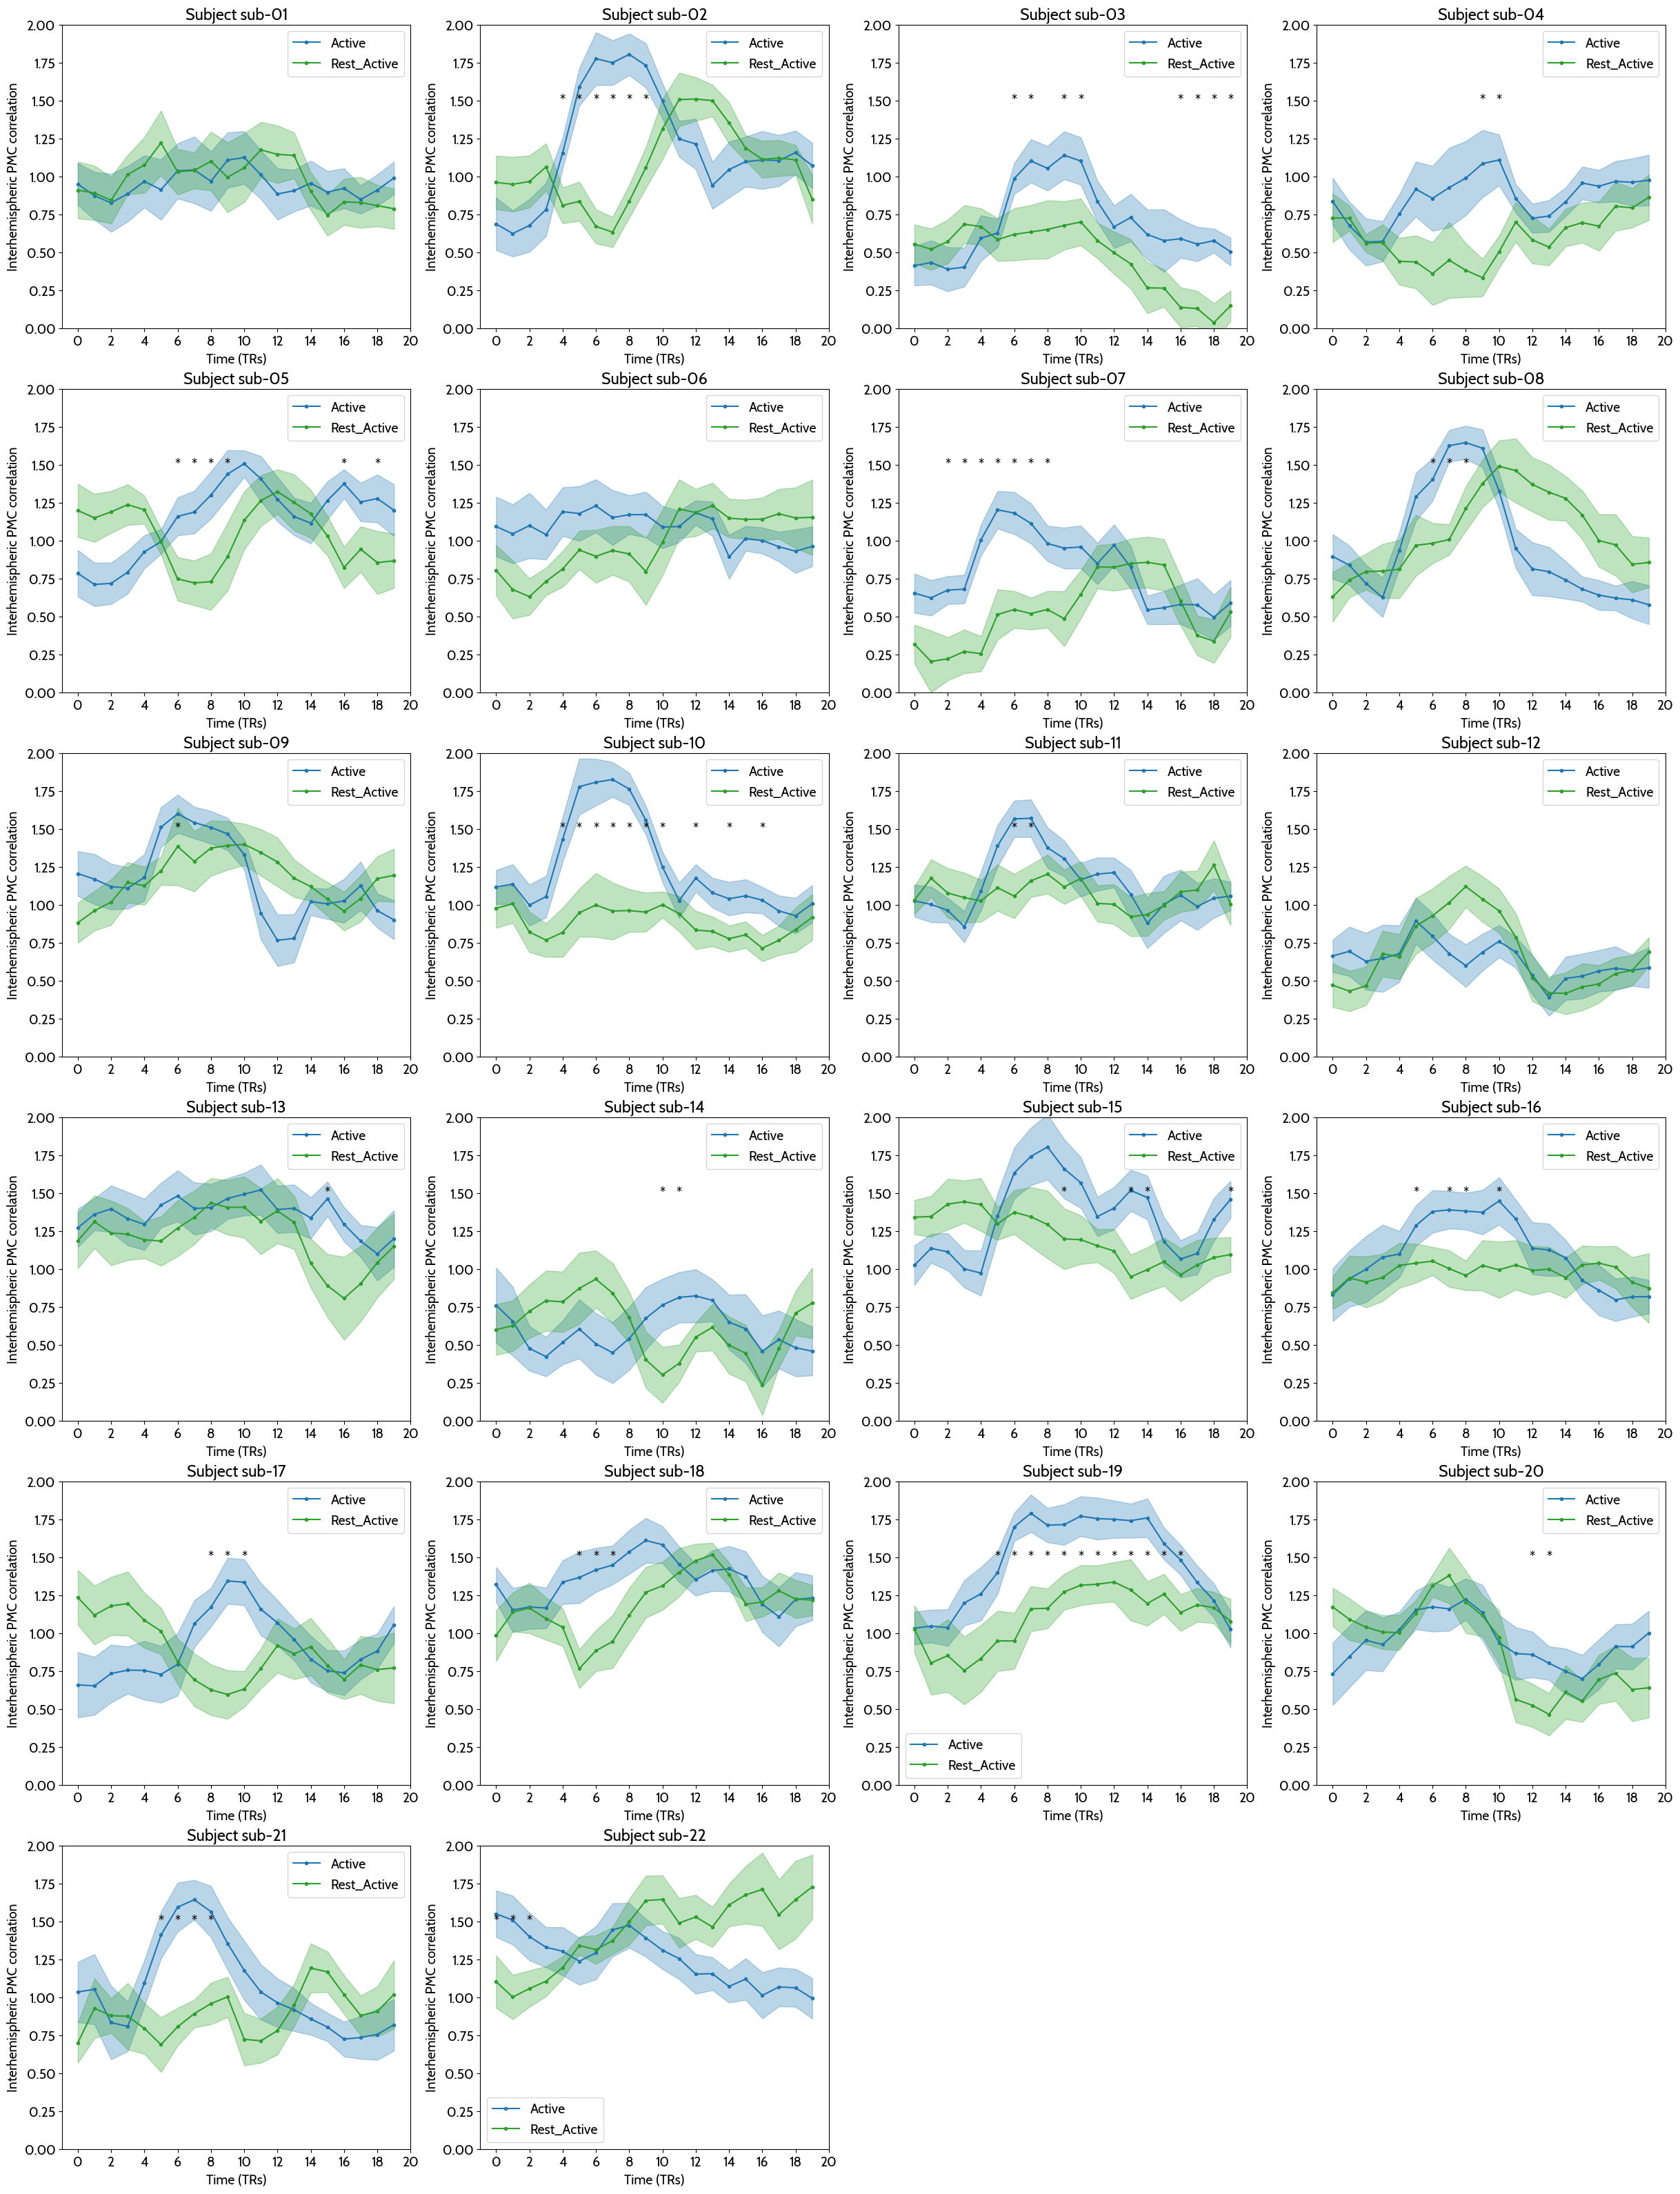

In [47]:
# | label: fig-tbv-correlation-timecourses
# colors use the lines colormap - blue for active, orange for sham, green for rest
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

colors = sns.color_palette("tab10", 3)

# Let's draw the time course of the correlation values for each participant in a single plot (subplots)
fig, axs = plt.subplots(6, 4, figsize=(30, 40))

for i, sub in enumerate(df["sub"].unique()):
    active_tcs = df[(df["sub"] == sub) & (df["feedback"] == "active")]["correlation_tc"]
    sham_tcs = df[(df["sub"] == sub) & (df["feedback"] == "sham")]["correlation_tc"]
    rest_active_tcs = df[(df["sub"] == sub) & (df["feedback"] == "rest_active")][
        "correlation_tc"
    ]
    rest_sham_tcs = df[(df["sub"] == sub) & (df["feedback"] == "rest_sham")][
        "correlation_tc"
    ]

    # stack and squeeze arrays
    active_tcs = np.squeeze(np.stack(active_tcs))
    sham_tcs = np.squeeze(np.stack(sham_tcs))
    rest_active_tcs = np.squeeze(np.stack(rest_active_tcs))
    rest_sham_tcs = np.squeeze(np.stack(rest_sham_tcs))

    # calculate means per timepoint
    active_tc_mean = np.nanmean(active_tcs, axis=0)
    active_tc_std = np.nanstd(active_tcs, axis=0) / np.sqrt(active_tcs.shape[0])

    sham_tc_mean = np.nanmean(sham_tcs, axis=0)
    sham_tc_std = np.nanstd(sham_tcs, axis=0) / np.sqrt(sham_tcs.shape[0])

    rest_active_tc_mean = np.nanmean(rest_active_tcs, axis=0)
    rest_active_tc_std = np.nanstd(rest_active_tcs, axis=0) / np.sqrt(
        rest_active_tcs.shape[0]
    )

    rest_sham_tc_mean = np.nanmean(rest_sham_tcs, axis=0)
    rest_sham_tc_std = np.nanstd(rest_sham_tcs, axis=0) / np.sqrt(
        rest_sham_tcs.shape[0]
    )

    # initialize arrays
    active_rest_p_bold = np.zeros(active_tc_mean.shape)

    # loop through timepoints and perform unpaired non parametric test between active and rest - mannwhitneyu
    for ii in range(active_tcs.shape[1]):
        active_rest_p_bold[ii] = mannwhitneyu(
            active_tcs[:, ii], rest_active_tcs[:, ii], alternative="greater"
        )[1]

    axs[i // 4, i % 4].plot(active_tc_mean, label="Active", marker=".", color=colors[0])
    # axs[i // 4, i % 4].plot(sham_tc_mean, label="Sham", marker="o")
    axs[i // 4, i % 4].plot(
        rest_active_tc_mean, label="Rest_Active", marker=".", color=colors[2]
    )
    # axs[i // 4, i % 4].plot(rest_sham_tc_mean, label="Rest_Sham", marker="o")
    axs[i // 4, i % 4].set_ylim(0, 2)
    axs[i // 4, i % 4].set_title(f"Subject {sub}")
    axs[i // 4, i % 4].legend()
    axs[i // 4, i % 4].set_xlabel("Time (TRs)")
    axs[i // 4, i % 4].set_ylabel("Interhemispheric PMC correlation")
    axs[i // 4, i % 4].fill_between(
        np.arange(len(active_tc_mean)),
        active_tc_mean - active_tc_std,
        active_tc_mean + active_tc_std,
        alpha=0.3,
        color=colors[0],
    )
    # axs[i // 4, i % 4].fill_between(
    #     np.arange(len(sham_tc_mean)),
    #     sham_tc_mean - sham_tc_std,
    #     sham_tc_mean + sham_tc_std,
    #     alpha=0.3,
    # )
    axs[i // 4, i % 4].fill_between(
        np.arange(len(rest_active_tc_mean)),
        rest_active_tc_mean - rest_active_tc_std,
        rest_active_tc_mean + rest_active_tc_std,
        alpha=0.3,
        color=colors[2],
    )
    # axs[i // 4, i % 4].fill_between(
    #     np.arange(len(rest_sham_tc_mean)),
    #     rest_sham_tc_mean - rest_sham_tc_std,
    #     rest_sham_tc_mean + rest_sham_tc_std,
    #     alpha=0.3,
    # )
    axs[i // 4, i % 4].set_xticks(range(0, 21, 2))

    # plot stat test with starts above the significant points
    for ii in np.where(active_rest_p_bold < 0.05)[0]:
        axs[i // 4, i % 4].text(
            ii, 1.5, "*", fontsize=14, color="black", ha="center", va="center"
        )

    # count the number of significant points
    print(f"Subject {sub} has {np.sum(active_rest_p_bold < 0.05)} significant points")

# hide the last two subplots
axs[5, 2].axis("off")
axs[5, 3].axis("off")

plt.show()

## Define modulator rule and retrieve number of modulators

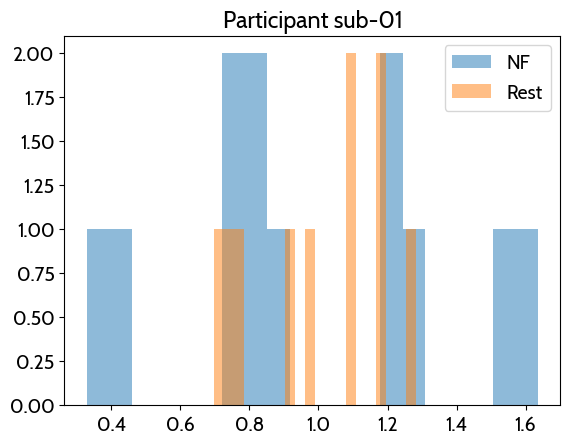

/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_17454/920828353.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  modulators = pd.concat(


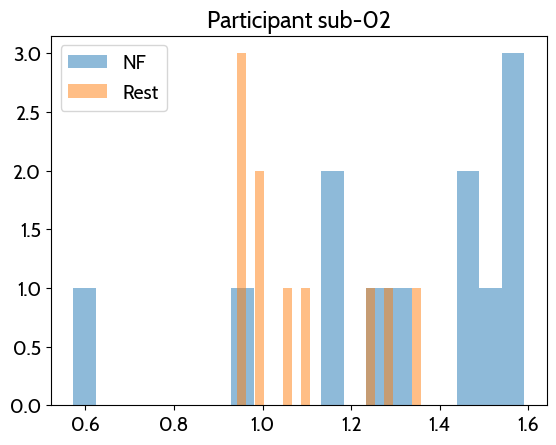

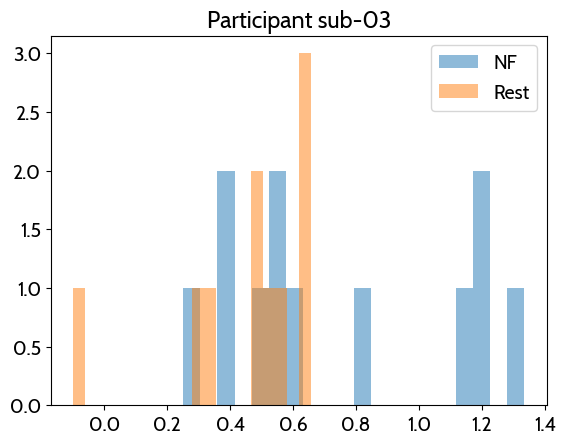

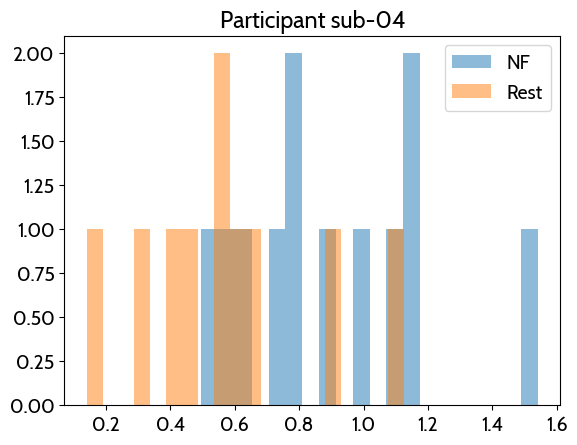

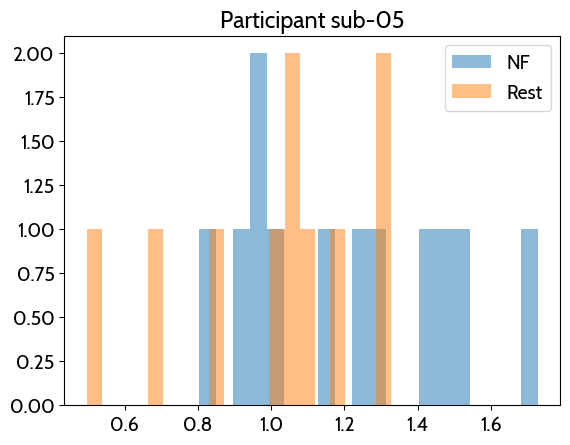

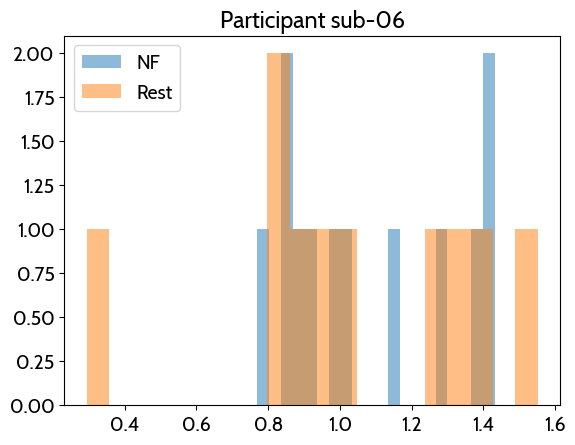

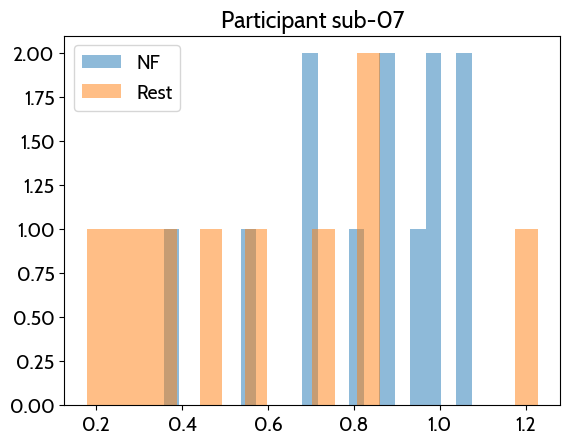

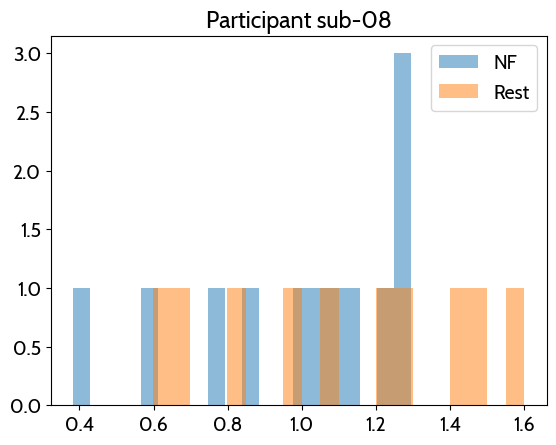

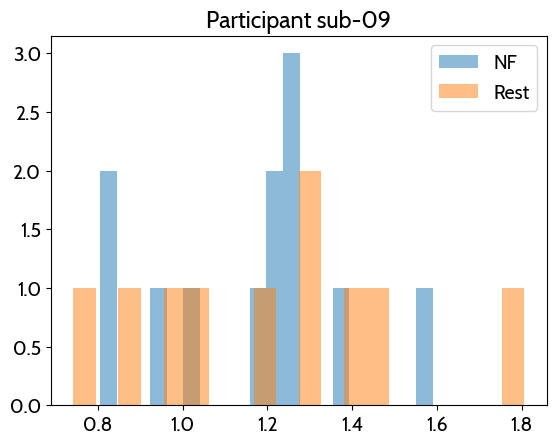

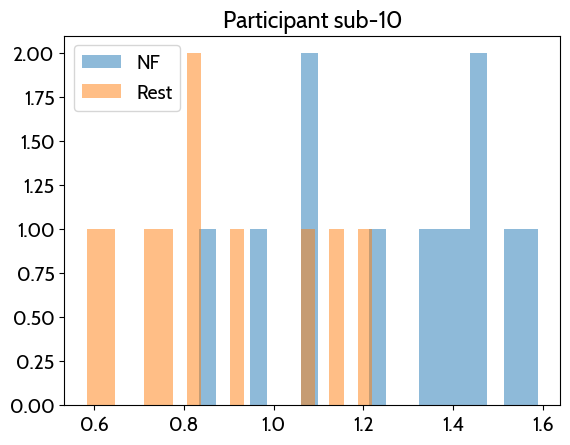

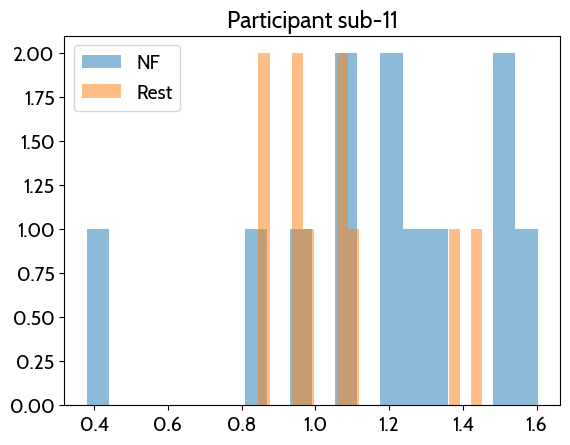

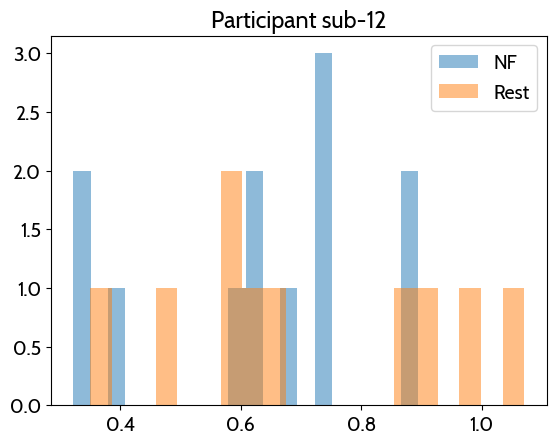

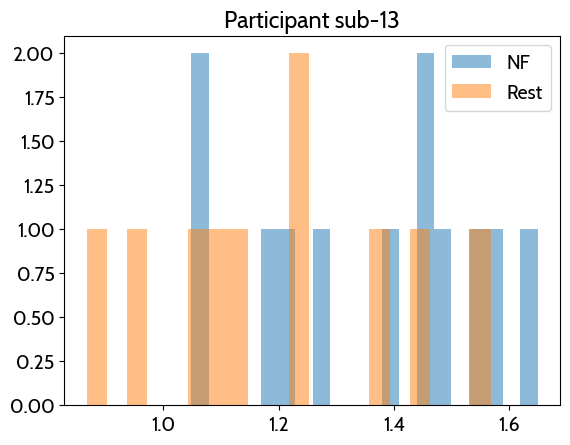

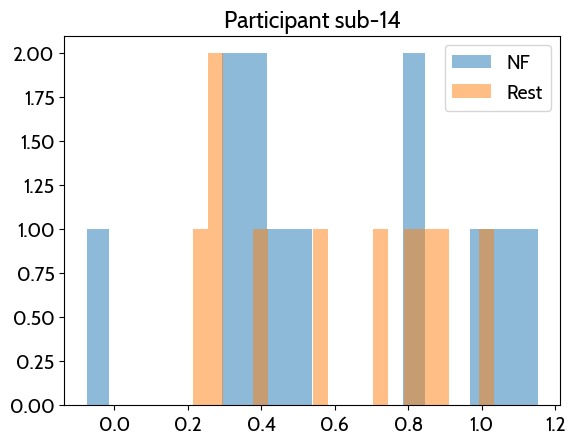

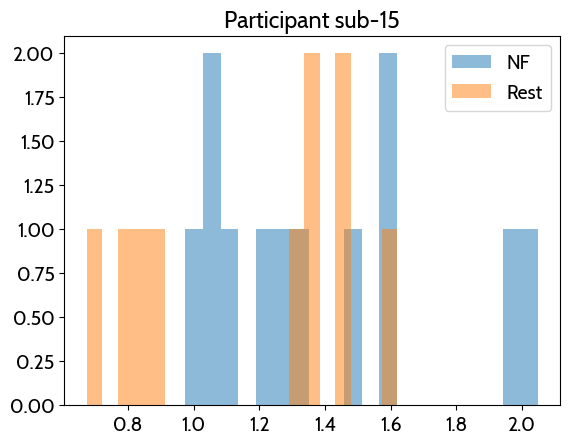

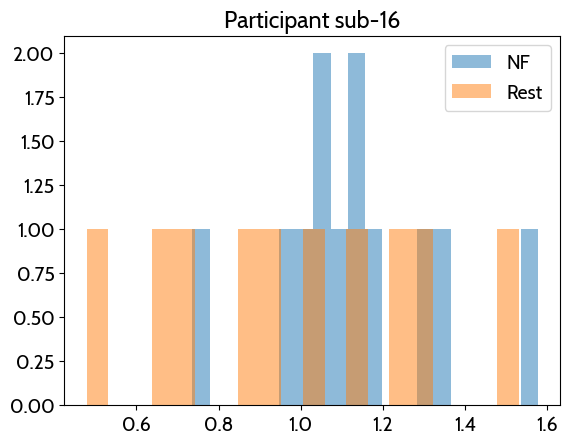

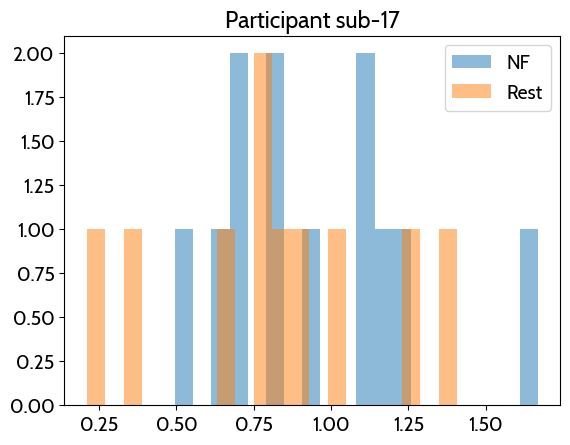

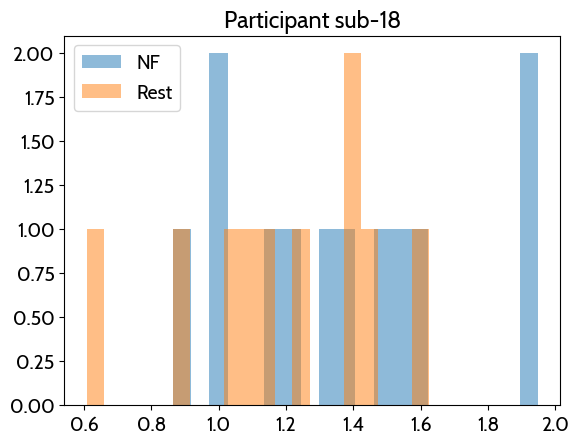

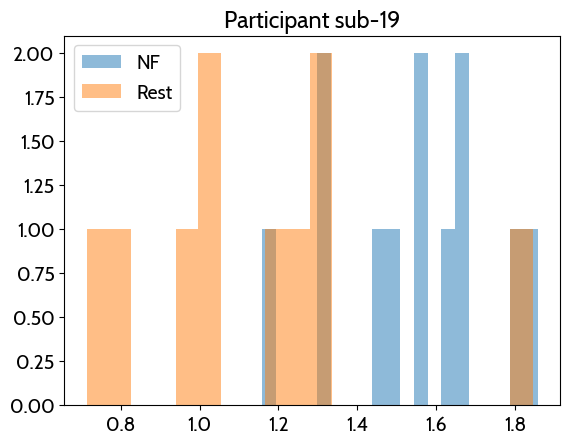

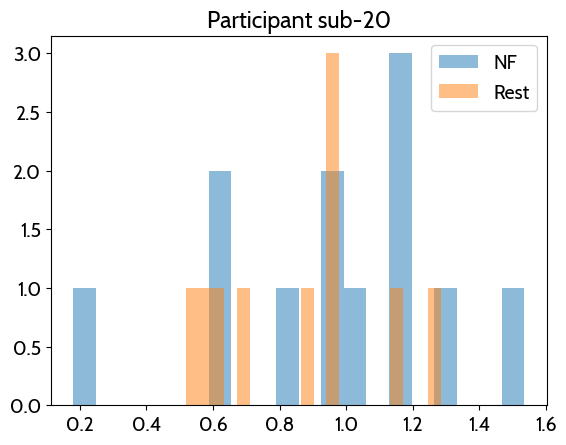

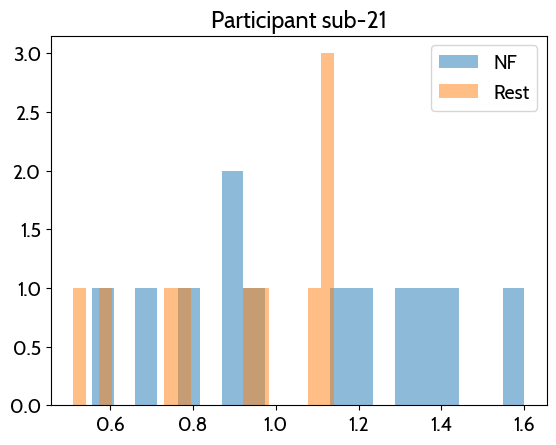

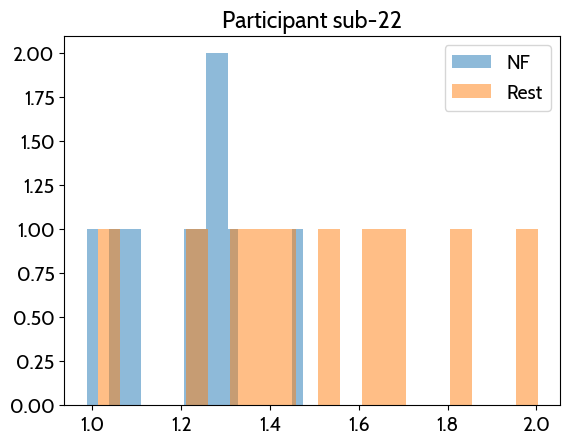

Number of modulators for active runs: 5
Number of modulators for sham runs: 7


,sub,mean_nf_corr,mean_rest_corr,pvalue,modulator_active,modulator_sham
0,sub-01,0.962485,0.993175,0.486850,False,False
0,sub-02,1.298010,1.085890,0.013590,True,False
0,sub-03,0.744021,0.452412,0.088231,False,False
0,sub-04,0.890845,0.574482,0.011457,True,True
0,sub-05,1.213030,1.011083,0.111260,False,True
0,sub-06,1.081990,1.031562,0.383340,False,False
0,sub-07,0.826606,0.577325,0.022157,True,False
0,sub-08,0.992871,1.112360,0.795094,False,True
0,sub-09,1.163370,1.214551,0.689536,False,False
0,sub-10,1.280417,0.871167,0.000868,True,True


In [ ]:
# lets make a comparison, per participant, of the correlation means between active/sham and rest.
# this will help us determine the subjects which were able to modulate or not
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

modulators = pd.DataFrame(
    columns=[
        "sub",
        "mean_nf_corr",
        "mean_rest_corr",
        "pvalue",
        "modulator_active",
        "modulator_sham",
    ]
)

for sub in df["sub"].unique():
    # participant data
    sub_data = df.loc[df["sub"] == sub]

    # get values
    sub_nf = sub_data["correlation_mean"].loc[(sub_data["feedback"] == "active")].values
    sub_rest = (
        sub_data["correlation_mean"].loc[(sub_data["feedback"] == "rest_active")].values
    )

    sub_nf_sham = (
        sub_data["correlation_mean"].loc[(sub_data["feedback"] == "sham")].values
    )
    sub_rest_sham = (
        sub_data["correlation_mean"].loc[(sub_data["feedback"] == "rest_sham")].values
    )

    # non parametric unpaired statistical test between them
    stat, p = mannwhitneyu(sub_nf, sub_rest, alternative="greater")
    stat_sham, p_sham = mannwhitneyu(sub_nf_sham, sub_rest_sham, alternative="greater")

    if p < 0.05:
        modulator_active = True
    else:
        modulator_active = False

    if p_sham < 0.05:
        modulator_sham = True
    else:
        modulator_sham = False

    modulators = pd.concat(
        [
            modulators,
            pd.DataFrame(
                [
                    [
                        sub,
                        np.nanmean(sub_nf),
                        np.nanmean(sub_rest),
                        p,
                        modulator_active,
                        modulator_sham,
                    ]
                ],
                columns=modulators.columns,
            ),
        ]
    )

# print the number of modulator==True for active and sham runs
print(f"Number of modulators for active runs: {modulators['modulator_active'].sum()}")
print(f"Number of modulators for sham runs: {modulators['modulator_sham'].sum()}")

modulators

# Line plots for the correlation time course
- subplots 1x2 for active and sham
- x-axis: time
- y-axis: correlation
- dataframe: df_persubject

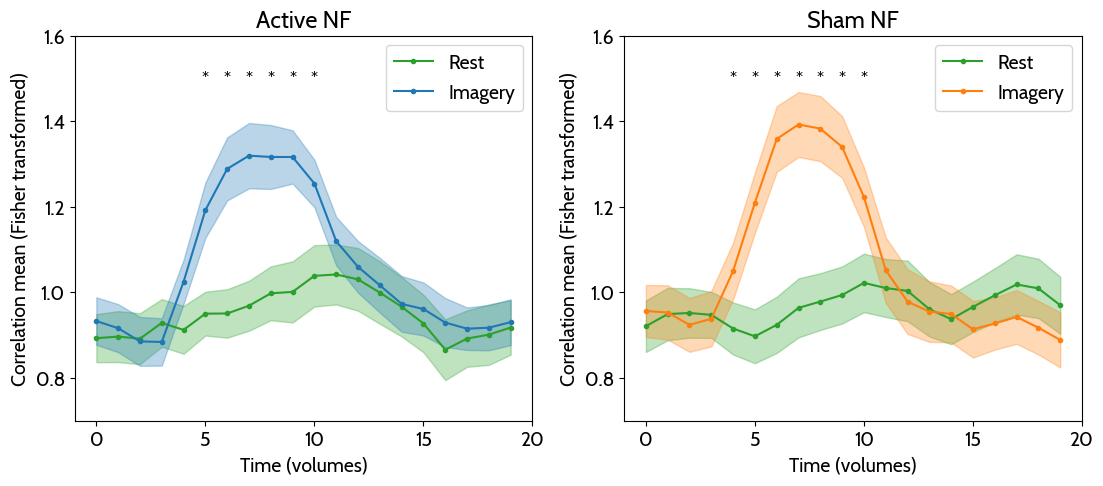

In [ ]:
from scipy.stats import wilcoxon

# create arrays with the correlation values for each subject
active_tcs = np.squeeze(
    np.stack(
        df_persubject.loc[(slice(None), "active"), "correlation_tc"].values, axis=0
    )
)
sham_tcs = np.squeeze(
    np.stack(df_persubject.loc[(slice(None), "sham"), "correlation_tc"].values, axis=0)
)
rest_active_tcs = np.squeeze(
    np.stack(
        df_persubject.loc[(slice(None), "rest_active"), "correlation_tc"].values, axis=0
    )
)
rest_sham_tcs = np.squeeze(
    np.stack(
        df_persubject.loc[(slice(None), "rest_sham"), "correlation_tc"].values, axis=0
    )
)

# calculate means per timepoint
active_mean_tc = np.nanmean(active_tcs, axis=0)
sham_mean_tc = np.nanmean(sham_tcs, axis=0)
rest_active_mean_tc = np.nanmean(rest_active_tcs, axis=0)
rest_sham_mean_tc = np.nanmean(rest_sham_tcs, axis=0)

# calculate standard error of the mean per timepoint
active_sem_tc = np.nanstd(active_tcs, axis=0) / np.sqrt(active_tcs.shape[0])
sham_sem_tc = np.nanstd(sham_tcs, axis=0) / np.sqrt(sham_tcs.shape[0])
rest_active_sem_tc = np.nanstd(rest_active_tcs, axis=0) / np.sqrt(
    rest_active_tcs.shape[0]
)
rest_sham_sem_tc = np.nanstd(rest_sham_tcs, axis=0) / np.sqrt(rest_sham_tcs.shape[0])

# calculate pointwise statistical differences between active and rest / sham and rest_sham. use non parametric stats

# initialize arrays
active_rest_p = np.zeros(active_mean_tc.shape)
sham_rest_p = np.zeros(sham_mean_tc.shape)

# loop through timepoints
for ii in range(active_tcs.shape[1]):
    active_rest_p[ii] = wilcoxon(active_tcs[:, ii], rest_active_tcs[:, ii])[1]
    sham_rest_p[ii] = wilcoxon(sham_tcs[:, ii], rest_sham_tcs[:, ii])[1]


# initialize subplots
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# subplot 1:
# plot rest
ax[0].plot(rest_active_mean_tc, color=colors[2], label="Rest", marker="o", markersize=3)
ax[0].fill_between(
    np.arange(rest_active_mean_tc.shape[0]),
    rest_active_mean_tc - rest_active_sem_tc,
    rest_active_mean_tc + rest_active_sem_tc,
    color=colors[2],
    alpha=0.3,
)
# plot active
ax[0].plot(active_mean_tc, color=colors[0], label="Imagery", marker="o", markersize=3)
ax[0].fill_between(
    np.arange(active_mean_tc.shape[0]),
    active_mean_tc - active_sem_tc,
    active_mean_tc + active_sem_tc,
    color=colors[0],
    alpha=0.3,
)
# plot stat test with starts above the significant points
for ii in np.where(active_rest_p < 0.05)[0]:
    ax[0].text(ii, 1.5, "*", fontsize=12, color="black", ha="center", va="center")
# settings
ax[0].set_xlim(-1, 20)
ax[0].set_ylim(0.7, 1.6)
ax[0].set_ylabel("Correlation mean (Fisher transformed)")
ax[0].set_xlabel("Time (volumes)")
ax[0].set_title("Active NF")
ax[0].legend()

# subplot 2 :
# plot rest
ax[1].plot(rest_sham_mean_tc, color=colors[2], label="Rest", marker="o", markersize=3)
ax[1].fill_between(
    np.arange(rest_sham_mean_tc.shape[0]),
    rest_sham_mean_tc - rest_sham_sem_tc,
    rest_sham_mean_tc + rest_sham_sem_tc,
    color=colors[2],
    alpha=0.3,
)
# plot sham
ax[1].plot(sham_mean_tc, color=colors[1], label="Imagery", marker="o", markersize=3)
ax[1].fill_between(
    np.arange(sham_mean_tc.shape[0]),
    sham_mean_tc - sham_sem_tc,
    sham_mean_tc + sham_sem_tc,
    color=colors[1],
    alpha=0.3,
)
# plot stat test with starts above the significant points
for ii in np.where(sham_rest_p < 0.05)[0]:
    ax[1].text(ii, 1.5, "*", fontsize=12, color="black", ha="center", va="center")
# settings
ax[1].set_xlim(-1, 20)
ax[1].set_ylim(0.7, 1.6)
ax[1].set_ylabel("Correlation mean (Fisher transformed)")
ax[1].set_xlabel("Time (volumes)")
ax[1].set_title("Sham NF")
ax[1].legend()


# Line plots for the BOLD time courses of the two ROIs

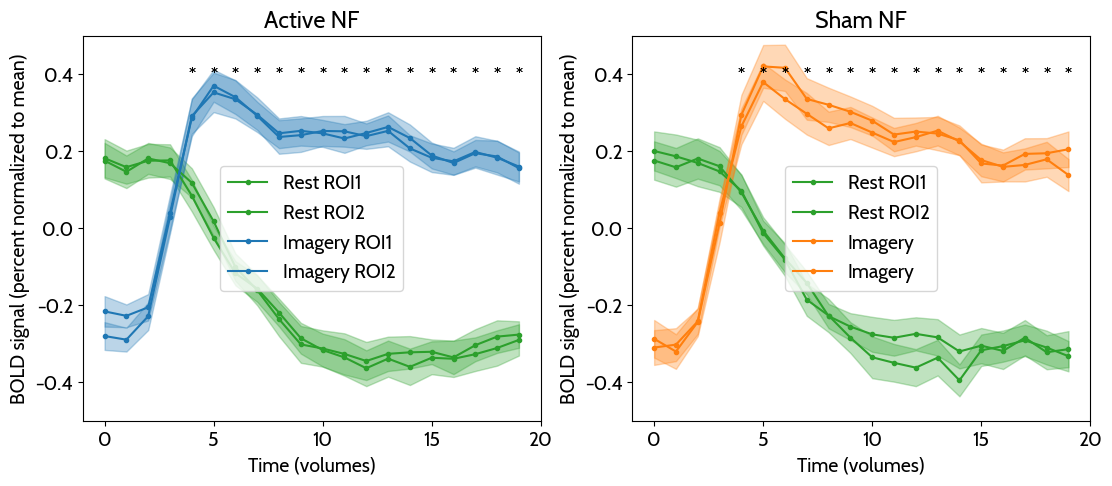

In [ ]:
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns

# colors use the lines colormap - blue for active, orange for sham, green for rest
colors = sns.color_palette("tab10", 3)

# create arrays with the bold values for each subject
active_bold = np.stack(
    df_persubject.loc[(slice(None), "active"), "bold_tcs"].values, axis=0
)
sham_bold = np.stack(
    df_persubject.loc[(slice(None), "sham"), "bold_tcs"].values, axis=0
)
rest_active_bold = np.stack(
    df_persubject.loc[(slice(None), "rest_active"), "bold_tcs"].values, axis=0
)
rest_sham_bold = np.stack(
    df_persubject.loc[(slice(None), "rest_sham"), "bold_tcs"].values, axis=0
)

# calculate means per timepoint
active_mean_bold = np.nanmean(active_bold, axis=0)
sham_mean_bold = np.nanmean(sham_bold, axis=0)
rest_active_mean_bold = np.nanmean(rest_active_bold, axis=0)
rest_sham_mean_bold = np.nanmean(rest_sham_bold, axis=0)

# calculate standard error of the mean per timepoint
active_sem_bold = np.nanstd(active_bold, axis=0) / np.sqrt(active_bold.shape[0])
sham_sem_bold = np.nanstd(sham_bold, axis=0) / np.sqrt(sham_bold.shape[0])
rest_active_sem_bold = np.nanstd(rest_active_bold, axis=0) / np.sqrt(
    rest_active_bold.shape[0]
)
rest_sham_sem_bold = np.nanstd(rest_sham_bold, axis=0) / np.sqrt(
    rest_sham_bold.shape[0]
)

# calculate pointwise statistical differences between active and rest / sham and rest_sham. use non parametric stats

# initialize arrays
active_rest_p_bold = np.zeros(active_mean_bold.shape)
sham_rest_p_bold = np.zeros(sham_mean_bold.shape)

# loop through timepoints
for ii in range(active_bold.shape[1]):
    active_rest_p_bold[ii] = wilcoxon(
        active_bold[:, ii], rest_active_bold[:, ii], alternative="greater"
    )[1]
    sham_rest_p_bold[ii] = wilcoxon(
        sham_bold[:, ii], rest_sham_bold[:, ii], alternative="greater"
    )[1]

# initialize subplots
fig, ax = plt.subplots(1, 2, figsize=(13, 5))

# subplot 1:
# plot rest
ax[0].plot(
    rest_active_mean_bold[:, 0],
    color=colors[2],
    label="Rest ROI1",
    marker="o",
    markersize=3,
)
ax[0].plot(
    rest_active_mean_bold[:, 1],
    color=colors[2],
    label="Rest ROI2",
    marker="o",
    markersize=3,
)
for rr in range(2):
    ax[0].fill_between(
        np.arange(rest_active_mean_bold.shape[0]),
        rest_active_mean_bold[:, rr] - rest_active_sem_bold[:, rr],
        rest_active_mean_bold[:, rr] + rest_active_sem_bold[:, rr],
        color=colors[2],
        alpha=0.3,
    )

# plot active
ax[0].plot(
    active_mean_bold[:, 0],
    color=colors[0],
    label="Imagery ROI1",
    marker="o",
    markersize=3,
)
ax[0].plot(
    active_mean_bold[:, 1],
    color=colors[0],
    label="Imagery ROI2",
    marker="o",
    markersize=3,
)
for rr in range(2):
    ax[0].fill_between(
        np.arange(active_mean_bold.shape[0]),
        active_mean_bold[:, rr] - active_sem_bold[:, rr],
        active_mean_bold[:, rr] + active_sem_bold[:, rr],
        color=colors[0],
        alpha=0.3,
    )

# plot stat test with starts above the significant points
for ii in np.where(active_rest_p_bold < 0.05)[0]:
    ax[0].text(ii, 0.4, "*", fontsize=12, color="black", ha="center", va="center")

# settings
ax[0].set_xlim(-1, 20)
ax[0].set_ylim(-0.5, 0.5)
ax[0].set_ylabel("BOLD signal (percent normalized to mean)")
ax[0].set_xlabel("Time (volumes)")

ax[0].set_title("Active NF")
ax[0].legend()

# subplot 2 :
# plot rest
ax[1].plot(
    rest_sham_mean_bold[:, 0],
    color=colors[2],
    label="Rest ROI1",
    marker="o",
    markersize=3,
)
ax[1].plot(
    rest_sham_mean_bold[:, 1],
    color=colors[2],
    label="Rest ROI2",
    marker="o",
    markersize=3,
)

for rr in range(2):
    ax[1].fill_between(
        np.arange(rest_sham_mean_bold.shape[0]),
        rest_sham_mean_bold[:, rr] - rest_sham_sem_bold[:, rr],
        rest_sham_mean_bold[:, rr] + rest_sham_sem_bold[:, rr],
        color=colors[2],
        alpha=0.3,
    )

# plot sham
ax[1].plot(sham_mean_bold, color=colors[1], label="Imagery", marker="o", markersize=3)
for rr in range(2):
    ax[1].fill_between(
        np.arange(sham_mean_bold.shape[0]),
        sham_mean_bold[:, rr] - sham_sem_bold[:, rr],
        sham_mean_bold[:, rr] + sham_sem_bold[:, rr],
        color=colors[1],
        alpha=0.3,
    )

# plot stat test with starts above the significant points
for ii in np.where(sham_rest_p_bold < 0.05)[0]:
    ax[1].text(ii, 0.4, "*", fontsize=12, color="black", ha="center", va="center")

# settings
ax[1].set_xlim(-1, 20)
ax[1].set_ylim(-0.5, 0.5)
ax[1].set_ylabel("BOLD signal (percent normalized to mean)")
ax[1].set_xlabel("Time (volumes)")
ax[1].set_title("Sham NF")
ax[1].legend()


# Legacy

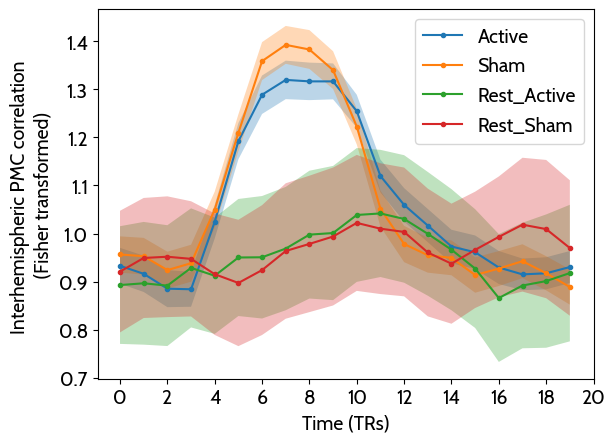

In [ ]:
# | label: fig-tbv-correlation-timecourses-average
# Let's draw a time course for the correlation values

# get all the active TCs
active_tcs = df[df["feedback"] == "active"]["correlation_tc"]

# average across subjects for each timepoint
active_tc_mean = np.nanmean(np.stack(active_tcs), axis=0)
active_tc_std = np.nanstd(np.stack(active_tcs), axis=0)

# get all the sham TCs
sham_tcs = df[df["feedback"] == "sham"]["correlation_tc"]

# average across subjects for each timepoint
sham_tc_mean = np.nanmean(np.stack(sham_tcs), axis=0)
sham_tc_std = np.nanstd(np.stack(sham_tcs), axis=0)

# get all the rest TCs
rest_active_tcs = df[df["feedback"] == "rest_active"]["correlation_tc"]
rest_sham_tcs = df[df["feedback"] == "rest_sham"]["correlation_tc"]

# average across subjects for each timepoint
rest_active_tc_mean = np.nanmean(np.stack(rest_active_tcs), axis=0)
rest_active_tc_std = np.nanstd(np.stack(rest_active_tcs), axis=0)
rest_sham_tc_mean = np.nanmean(np.stack(rest_sham_tcs), axis=0)
rest_sham_tc_std = np.nanstd(np.stack(rest_sham_tcs), axis=0)

# Ensure 1-dimensional arrays
active_tc_mean = np.squeeze(active_tc_mean)
active_tc_std = np.squeeze(active_tc_std) / np.sqrt(len(active_tcs))
sham_tc_mean = np.squeeze(sham_tc_mean)
sham_tc_std = np.squeeze(sham_tc_std) / np.sqrt(len(sham_tcs))
rest_active_tc_mean = np.squeeze(rest_active_tc_mean)
rest_active_tc_std = np.squeeze(rest_active_tc_std) / np.sqrt(len(rest_active_tc_std))
rest_sham_tc_mean = np.squeeze(rest_sham_tc_mean)
rest_sham_tc_std = np.squeeze(rest_sham_tc_std) / np.sqrt(len(rest_sham_tc_std))

# plot the two time courses with error bars
plt.plot(active_tc_mean, label="Active", marker="o", markersize=3)
plt.plot(sham_tc_mean, label="Sham", marker="o", markersize=3)
plt.plot(rest_active_tc_mean, label="Rest_Active", marker="o", markersize=3)
plt.plot(rest_sham_tc_mean, label="Rest_Sham", marker="o", markersize=3)
plt.fill_between(
    np.arange(len(active_tc_mean)),
    active_tc_mean - active_tc_std,
    active_tc_mean + active_tc_std,
    alpha=0.3,
)
plt.fill_between(
    np.arange(len(sham_tc_mean)),
    sham_tc_mean - sham_tc_std,
    sham_tc_mean + sham_tc_std,
    alpha=0.3,
)
plt.fill_between(
    np.arange(len(rest_active_tc_mean)),
    rest_active_tc_mean - rest_active_tc_std,
    rest_active_tc_mean + rest_active_tc_std,
    alpha=0.3,
)
plt.fill_between(
    np.arange(len(rest_sham_tc_mean)),
    rest_sham_tc_mean - rest_sham_tc_std,
    rest_sham_tc_mean + rest_sham_tc_std,
    alpha=0.3,
)
plt.legend()
plt.xlabel("Time (TRs)")
plt.ylabel("Interhemispheric PMC correlation \n(Fisher transformed)")
# plt.ylim(0.5, 0.9)
plt.xticks(range(0, 21, 2))
plt.show()

## Feedback signal basis - in the three last subjects

In [34]:
# The only ones with sham data
npy_files_2 = npy_files[78:]

In [ ]:
# Initalize the data frame
df_2 = pd.DataFrame(
    columns=[
        "sub",
        "feedback",
        "correlation_tc",
        "correlation_mean",
        "correlation_mean_first_half",
        "correlation_mean_second_half",
    ]
)

# Loop through all the files
for npy_file in npy_files_2:
    # Get the subject number
    sub = npy_file.split("_")[0]

    # Get the feedback type
    feedback = npy_file.split("_")[2].lower()

    # Load the file
    data = np.load(os.path.join(npy_path, npy_file))

    if feedback == "active":
        pc = data["PearsonCorr"]
        rest_str = "rest_active"
    elif feedback == "sham":
        pc = data["PearsonCorrSham"]
        rest_str = "rest_sham"

    # delete all numbers above 1 and below -1 (invalid values due to window)
    pc[pc > 1] = np.nan
    pc[pc < -1] = np.nan

    # fisher transform
    # pc = np.arctanh(pc)

    # Get the correlations values for the Motor Imagery per trial and add to the data frame
    for ii in range(len(indexes_mi)):
        pc_mi = pc[indexes_mi[ii]]

        df_2 = pd.concat(
            [
                df_2,
                pd.DataFrame(
                    [
                        [
                            sub,
                            feedback,
                            pc_mi,
                            np.nanmean(pc_mi),
                            np.nanmean(pc_mi[3:10]),
                            np.nanmean(pc_mi[10:]),
                        ]
                    ],
                    columns=df.columns,
                ),
            ]
        )

    # Get the correlations values for the Rest per trial and add to the data frame
    for ii in range(len(indexes_rest)):
        pc_rest = pc[indexes_rest[ii]]

        df_2 = pd.concat(
            [
                df_2,
                pd.DataFrame(
                    [
                        [
                            sub,
                            rest_str,
                            pc_rest,
                            np.nanmean(pc_rest),
                            np.nanmean(pc_rest[3:10]),
                            np.nanmean(pc_rest[10:]),
                        ]
                    ],
                    columns=df.columns,
                ),
            ]
        )


/var/folders/nd/bgqkn02j7sl982jdtqhts9z00000gn/T/ipykernel_19720/1343205880.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_2 = pd.concat(


np.float64(1.046043324523406e-14)

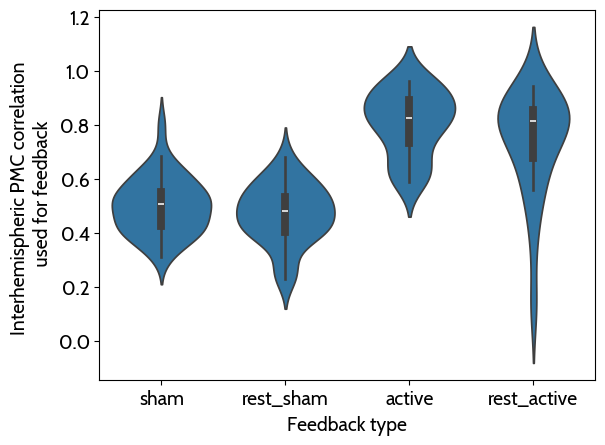

In [ ]:
# | label: fig-tbv-feedback-provided
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

sns.violinplot(x="feedback", y="correlation_mean_first_half", data=df_2)
plt.ylabel("Interhemispheric PMC correlation \n used for feedback")
plt.xlabel("Feedback type")

# test for statistical difference between the means

fb1 = df_2[df_2["feedback"] == "active"]["correlation_mean_first_half"]
fb2 = df_2[df_2["feedback"] == "sham"]["correlation_mean_first_half"]


ttest_ind(fb1, fb2, nan_policy="omit")[1] * 2